# Deep Q-Learning (DQN) Based Roulette Agent
* Uses a neural network to approximate Q-values
* Learns directly from continuous states
* Avoids Q-table size explosion
* Compares performance to prior agents

In [1]:
# Imports
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

# Optional seaborn for later plots
import seaborn as sns
sns.set(style="whitegrid")

# Allow imports from parent
sys.path.append("..")  # adjust if needed

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Environment wrapper for DQN

from config import BET_LIMITS, PAYOUTS
from utils import spin_wheel, is_red, is_black, is_even, is_odd, is_high, is_low

ACTIONS = (
    [{"type": b, "target": b} for b in ["red", "black", "even", "odd", "high", "low"]] +
    [{"type": "straight", "target": n} for n in range(37)]
)
ACTION_SPACE_SIZE = len(ACTIONS)
fixed_bet_amount = 20

class DQNRouletteEnv:
    def __init__(self, starting_bankroll=1000):
        self.starting_bankroll = starting_bankroll
        self.reset()

    def reset(self):
        self.bankroll = self.starting_bankroll
        self.peak = self.starting_bankroll
        self.round = 0
        self.win_streak = 0
        self.loss_streak = 0
        self.last_win = None
        self.last_outcome = None
        return self._get_state()

    def _get_state(self):
        return np.array([
            self.bankroll / 1000.0,                         # normalized bankroll
            (self.peak - self.bankroll) / 1000.0,           # normalized drawdown
            self.win_streak / 10.0,
            self.loss_streak / 10.0,
            1.0 if self.last_win else 0.0 if self.last_win is not None else 0.5
        ], dtype=np.float32)

    def step(self, action_idx):
        self.round += 1
        action = ACTIONS[action_idx]
        amount = fixed_bet_amount

        if self.bankroll < BET_LIMITS["outside"]["min"]:
            return self._get_state(), -200.0, True  # bust penalty

        outcome = spin_wheel()
        win = self._evaluate(action, outcome)
        payout = amount * PAYOUTS[action["type"]] if win else -amount
        self.bankroll += payout
        self.peak = max(self.peak, self.bankroll)

        self.last_win = win
        self.win_streak = self.win_streak + 1 if win else 0
        self.loss_streak = self.loss_streak + 1 if not win else 0

        # Reward shaping
        reward = payout
        if self.bankroll < self.starting_bankroll * 0.5:
            reward -= 100
        if self.bankroll > self.starting_bankroll * 1.5:
            reward += 50
        if self.round % 100 == 0:
            reward += 10
        if self.loss_streak >= 5:
            reward -= 25

        done = self.bankroll < BET_LIMITS["outside"]["min"] or self.round >= 1000
        return self._get_state(), reward, done

    def _evaluate(self, action, outcome):
        if action["type"] == "red":
            return is_red(outcome)
        elif action["type"] == "black":
            return is_black(outcome)
        elif action["type"] == "odd":
            return is_odd(outcome)
        elif action["type"] == "even":
            return is_even(outcome)
        elif action["type"] == "high":
            return is_high(outcome)
        elif action["type"] == "low":
            return is_low(outcome)
        elif action["type"] == "straight":
            return outcome == action["target"]
        return False


In [3]:
# Define the Q-network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
# Experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(next_states, dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)
        )

    def __len__(self):
        return len(self.buffer)


In [5]:
# DQN Training Loop

# Hyperparameters
num_episodes = 1000
max_steps = 1000
batch_size = 64
gamma = 0.99
learning_rate = 0.001
epsilon = 1.0
min_epsilon = 0.1
epsilon_decay = 0.995
target_update_freq = 10
replay_capacity = 10000

# Model setup
env = DQNRouletteEnv()
state_dim = env.reset().shape[0]
policy_net = DQN(state_dim, ACTION_SPACE_SIZE).to(device)
target_net = DQN(state_dim, ACTION_SPACE_SIZE).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
replay_buffer = ReplayBuffer(capacity=replay_capacity)

# Tracking
dqn_rewards = []
dqn_lengths = []

for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for t in range(max_steps):
        # Epsilon-greedy action
        if random.random() < epsilon:
            action = random.randint(0, ACTION_SPACE_SIZE - 1)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                q_values = policy_net(state_tensor)
                action = int(torch.argmax(q_values))

        next_state, reward, done = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Sample and train
        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

            # Q(s,a) predictions
            q_values = policy_net(states).gather(1, actions)

            # Q_target(s', a')
            with torch.no_grad():
                max_next_q = target_net(next_states).max(1)[0].unsqueeze(1)
                q_targets = rewards + gamma * max_next_q * (1 - dones)

            # Loss and update
            loss = loss_fn(q_values, q_targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Epsilon decay
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Target network update
    if ep % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    dqn_rewards.append(total_reward)
    dqn_lengths.append(t + 1)

    if (ep + 1) % 100 == 0:
        print(f"Episode {ep+1}/{num_episodes} | Reward: {total_reward:.2f} | Steps: {t+1} | Epsilon: {epsilon:.3f}")


C:\Users\JR\AppData\Local\Temp\ipykernel_1144\1246805767.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  torch.tensor(states, dtype=torch.float32).to(device),


Episode 100/1000 | Reward: 16580.00 | Steps: 858 | Epsilon: 0.606
Episode 200/1000 | Reward: 40870.00 | Steps: 1000 | Epsilon: 0.367
Episode 300/1000 | Reward: -6565.00 | Steps: 140 | Epsilon: 0.222
Episode 400/1000 | Reward: -460.00 | Steps: 404 | Epsilon: 0.135
Episode 500/1000 | Reward: -5710.00 | Steps: 420 | Epsilon: 0.100
Episode 600/1000 | Reward: -4575.00 | Steps: 58 | Epsilon: 0.100
Episode 700/1000 | Reward: 2340.00 | Steps: 492 | Epsilon: 0.100
Episode 800/1000 | Reward: -6215.00 | Steps: 138 | Epsilon: 0.100
Episode 900/1000 | Reward: -9690.00 | Steps: 190 | Epsilon: 0.100
Episode 1000/1000 | Reward: 33190.00 | Steps: 1000 | Epsilon: 0.100


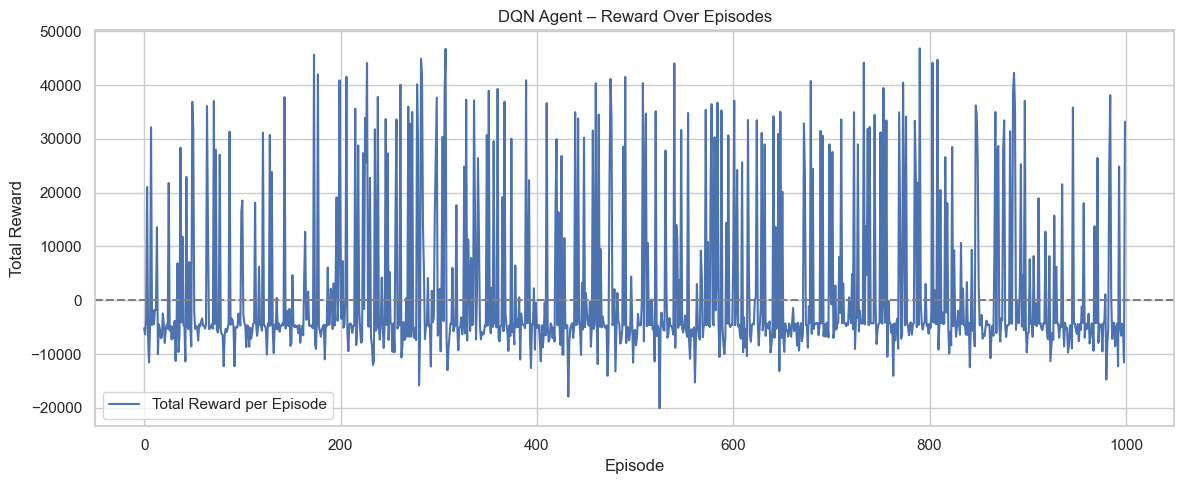

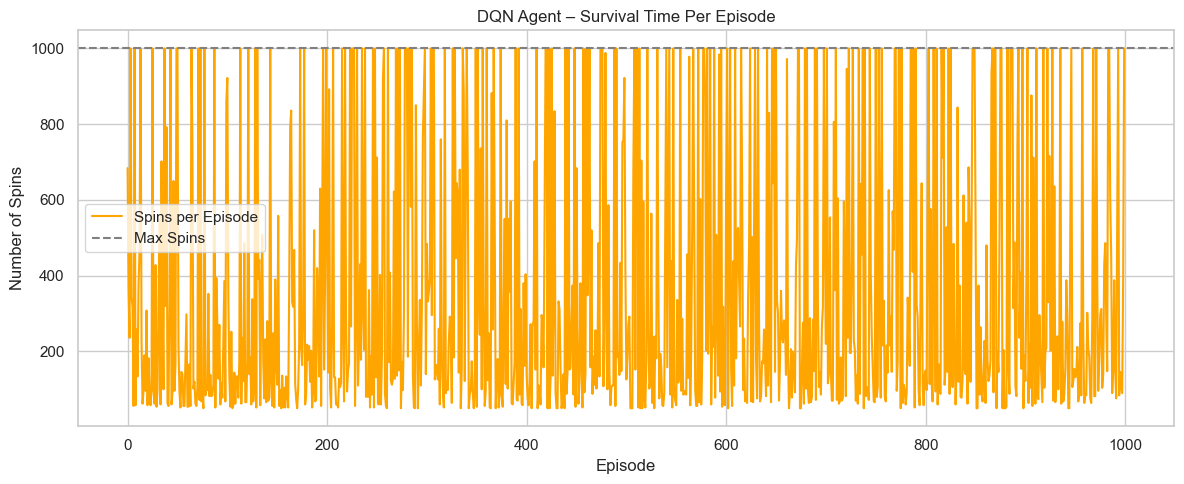

In [6]:
# DQN Training Progress – Reward and Episode Length

plt.figure(figsize=(12, 5))
plt.plot(dqn_rewards, label="Total Reward per Episode")
plt.axhline(0, color="gray", linestyle="--")
plt.title("DQN Agent – Reward Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(dqn_lengths, label="Spins per Episode", color="orange")
plt.axhline(1000, linestyle="--", color="gray", label="Max Spins")
plt.title("DQN Agent – Survival Time Per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Spins")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Evaluation of DQN agent (no exploration)
def evaluate_dqn_agent(policy_net, runs=100):
    rewards = []
    spins = []

    for _ in range(runs):
        env = DQNRouletteEnv()
        state = env.reset()
        total_reward = 0
        count = 0
        done = False

        while not done:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                q_values = policy_net(state_tensor)
                action = int(torch.argmax(q_values))

            state, reward, done = env.step(action)
            total_reward += reward
            count += 1

        rewards.append(total_reward)
        spins.append(count)

    return pd.DataFrame({
        "Strategy": "DQN Agent",
        "Reward": rewards,
        "Spins": spins
    })

df_dqn = evaluate_dqn_agent(policy_net)


In [8]:
# Summary of evaluation results
df_dqn.describe().round(2)

,Reward,Spins
count,100.00,100.00
mean,-607.75,432.70
std,9887.62,330.09
min,-13570.00,58.00
25%,-5755.00,165.50
50%,-4270.00,306.00
75%,-396.25,658.50
max,29235.00,1000.00
